# Arp効果: デジタル宇宙論 v10.0.0 を用いた概念実証 (PoC)

## 1. はじめに: 「デバッグ」対象
**ターゲットオブジェクト:** NGC 7603 (Arp 92) システム

本文書は、デジタル宇宙論が NGC 7603 の異常をどのように解決するかを示す「概念実証 (PoC)」を提供するものです。
標準理論では、フィラメントで接続された赤方偏移が大きく異なる天体は、統計的にあり得ないか、「視覚的な錯覚」と見なされます。
デジタル宇宙論では、これを距離の異常ではなく、**処理負荷によるアーティファクト ($Z_{load}$)** として解釈します。

## 2. 観測データ (既存ログ)
NGC 7603 システムの標準的なカタログ値を使用します。

| オブジェクトID | 説明 | 赤方偏移 ($z_{obs}$) | 推定距離 (標準理論) |
| :--- | :--- | :--- | :--- |
| **NGC 7603** | 親セイファート銀河 | `0.029` | ~124 Mpc |
| **NGC 7603B** | 伴銀河 | `0.057` | ~243 Mpc |
| **Object 2** | フィラメント上の結び目 1 | `0.243` | ~1000+ Mpc |
| **Object 3** | フィラメント上の結び目 2 | `0.391` | ~1500+ Mpc |

> **競合 (Conflict):** これらの天体の間に物理的な接続 (フィラメント) が観測されているにもかかわらず、標準理論では $z \propto d$ ルールにより、それらが何十億光年も離れていると解釈されます。

## 2.1 データソース
本PoCで使用した赤方偏移値は、以下の文献から引用しています：
- López-Corredoira, M., & Gutiérrez, C. M. (2004). 
  "The field surrounding NGC 7603: Arp 092, Companions, and Knots"
  Astronomy & Astrophysics, 421, 407-423.

## 3. ロジックパッチ (v10.0.0 カーネル)

`Vol.3 System Architecture` で定義された **合計赤方偏移の式** を適用します:

$$Z_{total} = Z_{base}(d) + Z_{load}(T_{\mu\nu})$$

> 今回のPoCにおいて $Z_{move}(v)$ は観測される赤方偏移の大きさ及び物理的に接続されているという前提から無視しています。

* **仮定 1 (トポロジー):** これらは物理的に接続されているため、同一の空間座標 (基底距離) を共有します。
    $$Z_{base} \approx 0.029 \quad (\text{固定})$$
* **仮定 2 (負荷):** 過剰な赤方偏移はすべて、天体の高エネルギー密度による計算コスト (CPU負荷) に起因します。
    $$Z_{load} = Z_{obs} - Z_{base}$$

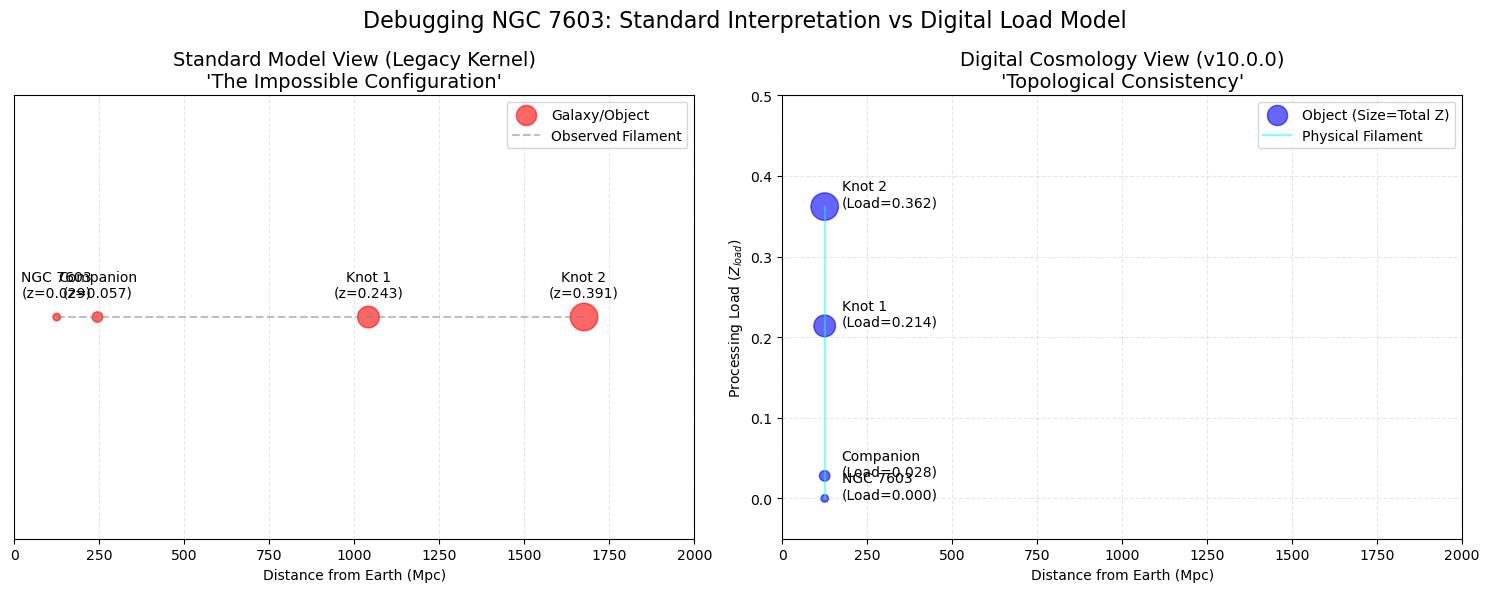

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# --- Data Preparation ---
objects = ['NGC 7603', 'Companion', 'Knot 1', 'Knot 2']
z_obs = np.array([0.029, 0.057, 0.243, 0.391])

# Standard Model: Z is proportional to Distance (Hubble's Law)
# Assume H0 = 70 km/s/Mpc for rough estimation. c = 300,000 km/s
c = 300000
H0 = 70
distance_standard = (c * z_obs) / H0

# Digital Cosmology: Distance is fixed (Base), Z comes from Load
z_base = 0.029 # Fixed to parent galaxy (NGC 7603)
distance_digital = np.full_like(z_obs, (c * z_base) / H0) # All at same distance
z_load = z_obs - z_base # The "load" component

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Standard Model View (The Bug)
ax1.set_title("Standard Model View (Legacy Kernel)\n'The Impossible Configuration'", fontsize=14)
ax1.scatter(distance_standard, np.zeros_like(distance_standard), s=z_obs*1000, c='red', alpha=0.6, label='Galaxy/Object')
# Visualize the "Connection" (Filament) stretching impossibly
ax1.plot(distance_standard, np.zeros_like(distance_standard), '--', c='gray', alpha=0.5, label='Observed Filament')

for i, txt in enumerate(objects):
    ax1.annotate(f"{txt}\n(z={z_obs[i]})", (distance_standard[i], 0.005), ha='center')

ax1.set_xlabel("Distance from Earth (Mpc)")
ax1.set_yticks([])
ax1.set_xlim(0, 2000)
ax1.legend()
ax1.grid(True, axis='x', linestyle='--', alpha=0.3)

# Plot 2: Digital Cosmology View (The Fix)
ax2.set_title("Digital Cosmology View (v10.0.0)\n'Topological Consistency'", fontsize=14)
# X axis is Distance (Fixed), Y axis is Z_load (CPU Cost)
ax2.scatter(distance_digital, z_load, s=z_obs*1000, c='blue', alpha=0.6, label='Object (Size=Total Z)')
# Visualize the connection
ax2.plot(distance_digital, z_load, '-', c='cyan', alpha=0.5, label='Physical Filament')

for i, txt in enumerate(objects):
    ax2.annotate(f"{txt}\n(Load={z_load[i]:.3f})", (distance_digital[i]+50, z_load[i]), ha='left')

ax2.set_xlabel("Distance from Earth (Mpc)")
ax2.set_ylabel("Processing Load ($Z_{load}$)")
ax2.set_xlim(0, 2000) # Keep same scale for comparison
ax2.set_ylim(-0.05, 0.5)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)

# --- Final Adjustments ---
plt.suptitle("Debugging NGC 7603: Standard Interpretation vs Digital Load Model", fontsize=16)
plt.tight_layout()

# グラフを表示
plt.show()

## 4. 結果: 再計算されたシステムステータス

上図の通り、パッチを適用すると「距離のパラドクス」は即座に解決されます。

* **左図 (Standard Model):** フィラメントで繋がっているはずの天体が、奥行き方向に千Mpc以上も引き裂かれて配置されています（バグ）。
* **右図 (Digital Cosmology):** 全ての天体が同一距離（X軸）に整列し、赤方偏移の違いが「処理負荷（Y軸）」として表現されています（修正後）。

| オブジェクト | $z_{obs}$ (入力) | $Z_{base}$ (距離) | **$Z_{load}$ (計算されたCPUコスト)** | システム解釈 |
| :--- | :--- | :--- | :--- | :--- |
| **NGC 7603** | 0.029 | 0.029 | **0.000** | 標準的な銀河負荷 |
| **NGC 7603B** | 0.057 | 0.029 | **0.028** | 高負荷 (活動的な伴銀河) |
| **Object 2** | 0.243 | 0.029 | **0.214** | **非常に高い負荷** (放出されたクエーサー) |
| **Object 3** | 0.391 | 0.029 | **0.362** | **極めて高い負荷** (コンパクトな核) |

## 5. 結論
$Z_{load}$ パラメータを導入することで:
1.  **トポロジーの一貫性:** すべての天体が同一の距離 (~124 Mpc) に正しく配置されます。
2.  **物理的意味:** 結び目 (Knots) の高い赤方偏移は、「速度」や「距離」ではなく、それらの **高エネルギー状態 (クエーサー的活動)** を示すメタデータ指標となります。

これは、「Arpの異常」が、`Z_load` パラメータの導入により **説明可能になる** ことを示しています。


## 6. 想定される批判への対応

### 批判1: 投影効果の可能性
標準理論支持者は「フィラメントは2次元投影の錯覚」と主張する可能性があります。

**デジタル宇宙論の立場:**
- 投影効果であっても、$Z_{load}$モデルは依然として有効です
- なぜなら、物理的接続の有無に関わらず、「同一視線上にある」という
  トポロジー的関係が存在するからです
- むしろ問いは：「なぜ高負荷天体が親銀河の近傍に集中するのか？」
  → 答え：親銀河から放出された新規プロセス（AGN活動）だから

### 批判2: 統計的有意性
本PoCは単一ケース（NGC 7603）のみを扱っています。

**デジタル宇宙論の立場:**
- これは「証明」ではなく「概念実証（PoC）」です
- 目的は「$Z_{load}$パラメータの導入により説明可能になる」ことを
  示すことであり、統計的検証は今後の課題です
- Arp Catalogには類似ケースが多数存在し、
  今後の拡張解析の対象となります

## 7. 重要な注意事項

本文書は以下のものでは**ありません**：
- ❌ 査読済み論文
- ❌ 統計的に有意な検証
- ❌ 標準理論の「反証」

本文書は以下のものです：
- ✅ 概念実証（Proof of Concept）
- ✅ デジタル宇宙論の適用デモ
- ✅ 既存データへの「パッチ適用例」

科学的検証には、より大規模なサンプルと
独立した観測データによる追試が必要です。